In [71]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [90]:
# Set random seeds for reproducibility
torch.set_num_threads(4) 

data = pd.read_csv('./meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Bollinger Bands
window = 20
data['BB_middle'] = data['Close'].rolling(window=window).mean()
data['BB_upper'] = data['BB_middle'] + 2*data['Close'].rolling(window=window).std()
data['BB_lower'] = data['BB_middle'] - 2*data['Close'].rolling(window=window).std()

# Price changes
data['Price_Change'] = data['Close'].pct_change()
data['Price_Change_5d'] = data['Close'].pct_change(periods=5)
data['Price_Change_21d'] = data['Close'].pct_change(periods=21)

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


# Calculate RSI
# def compute_RSI(data, window=14):
#     delta = data['Close'].diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
#     RS = gain / loss
#     return 100 - (100 / (1 + RS))

# data['RSI_14'] = compute_RSI(data)

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  


data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,...,EMA for 50 days,BB_middle,BB_upper,BB_lower,Price_Change,Price_Change_5d,Price_Change_21d,MACD,Signal_Line,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,...,30.538853,29.237800,34.169255,24.306345,-0.023413,-0.194783,-0.261798,-1.525536,-0.894611,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,...,30.192623,28.784750,34.691542,22.877958,-0.062203,-0.236907,-0.301817,-1.869091,-1.089507,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,...,29.827422,28.268750,35.028615,21.508885,-0.038231,-0.288344,-0.321439,-2.183168,-1.308239,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,...,29.443602,27.697250,35.208463,20.186037,-0.040230,-0.253492,-0.357692,-2.471369,-1.540865,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,...,29.116010,27.165250,34.975085,19.355415,0.052395,-0.110314,-0.329838,-2.585243,-1.749740,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,...,64.769416,66.626865,69.652270,63.601460,0.014325,0.022091,0.078620,1.037495,0.876412,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,...,64.945909,66.821865,70.004815,63.638915,-0.001873,0.031341,0.073953,1.134074,0.927944,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,...,65.194697,67.100365,70.808733,63.391997,0.029161,0.053651,0.090561,1.357958,1.013947,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,...,65.578435,67.477365,72.596013,62.358717,0.051760,0.129049,0.140901,1.812249,1.173608,71.536342


In [91]:
# Select key features
selected_features = ['Close', 'Volume', 'EMA for 50 days', 'MACD', 'RSI_14']

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[selected_features])

# Create sequences with reduced length
sequence_length = 30  # Reduced from 60
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader with larger batch size
batch_size = 128  # Increased batch size
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Simplified model architecture
input_dim = len(selected_features)
d_model = 128  # Reduced dimension
nhead = 4     # Reduced heads
num_encoder_layers = 2  # Reduced layers
hidden_dim = 64  # Reduced hidden dimension

# Define model components
input_projection = nn.Linear(input_dim, d_model)
layer_norm = nn.LayerNorm(d_model)
dropout = nn.Dropout(0.1)

encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=d_model * 2,  # Reduced feedforward dimension
    dropout=0.1,
    batch_first=True,
    activation=F.gelu
)

transformer_encoder = nn.TransformerEncoder(
    encoder_layer,
    num_layers=num_encoder_layers
)

lstm = nn.LSTM(
    input_size=d_model,
    hidden_size=hidden_dim,
    num_layers=1,  # Reduced LSTM layers
    batch_first=True,
    bidirectional=True,
    dropout=0.1
)

fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
fc2 = nn.Linear(hidden_dim, 1)

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [92]:
criterion = nn.MSELoss()  # Changed to simpler loss function
optimizer = torch.optim.Adam([
    {'params': input_projection.parameters()},
    {'params': transformer_encoder.parameters()},
    {'params': lstm.parameters()},
    {'params': fc1.parameters()},
    {'params': fc2.parameters()}
], lr=0.001)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

# Training loop
num_epochs = 50  # Reduced epochs
best_val_loss = float('inf')
patience = 7   # Reduced patience
patience_counter = 0
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # Training phase
    total_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        
        # Forward pass
        x = input_projection(batch_X)
        x = layer_norm(x)
        x = transformer_encoder(x)
        lstm_out, _ = lstm(x)
        x = fc1(lstm_out[:, -1, :])
        x = F.gelu(x)
        outputs = fc2(x)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Validation step (no device moving needed)
            
            x = input_projection(batch_X)
            x = layer_norm(x)
            x = transformer_encoder(x)
            lstm_out, _ = lstm(x)
            x = fc1(lstm_out[:, -1, :])
            x = F.gelu(x)
            outputs = fc2(x)
            
            loss = criterion(outputs.squeeze(), batch_y)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Print progress with batch count
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Batches: {len(train_loader)} - '
          f'Train Loss: {avg_train_loss:.6f} - '
          f'Val Loss: {avg_val_loss:.6f}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'input_projection': input_projection.state_dict(),
            'transformer_encoder': transformer_encoder.state_dict(),
            'lstm': lstm.state_dict(),
            'fc1': fc1.state_dict(),
            'fc2': fc2.state_dict()
        }, 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Batches: 17 - Train Loss: 0.023219 - Val Loss: 0.013504
Epoch [2/50] - Batches: 17 - Train Loss: 0.001287 - Val Loss: 0.004735
Epoch [3/50] - Batches: 17 - Train Loss: 0.000591 - Val Loss: 0.003740
Epoch [4/50] - Batches: 17 - Train Loss: 0.000454 - Val Loss: 0.003763
Epoch [5/50] - Batches: 17 - Train Loss: 0.000453 - Val Loss: 0.003732
Epoch [6/50] - Batches: 17 - Train Loss: 0.000322 - Val Loss: 0.003827
Epoch [7/50] - Batches: 17 - Train Loss: 0.000339 - Val Loss: 0.003281
Epoch [8/50] - Batches: 17 - Train Loss: 0.000275 - Val Loss: 0.003611
Epoch [9/50] - Batches: 17 - Train Loss: 0.000251 - Val Loss: 0.004197
Epoch [10/50] - Batches: 17 - Train Loss: 0.000265 - Val Loss: 0.003823
Epoch [11/50] - Batches: 17 - Train Loss: 0.000270 - Val Loss: 0.003655
Epoch [12/50] - Batches: 17 - Train Loss: 0.000230 - Val Loss: 0.004530
Epoch [13/50] - Batches: 17 - Train Loss: 0.000218 - Val Loss: 0.004168
Epoch [14/50] - Batches: 17 - Train Loss: 0.000240 - Val Loss: 0.003593
E

In [93]:
# Make predictions
predictions = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        x = input_projection(batch_X)
        x = layer_norm(x)
        x = transformer_encoder(x)
        lstm_out, _ = lstm(x)
        x = fc1(lstm_out[:, -1, :])
        x = F.gelu(x)
        outputs = fc2(x)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]


Final Model Performance Metrics:
MSE: 590.562
RMSE: 24.301
MAE: 19.403
R2 Score: 0.915


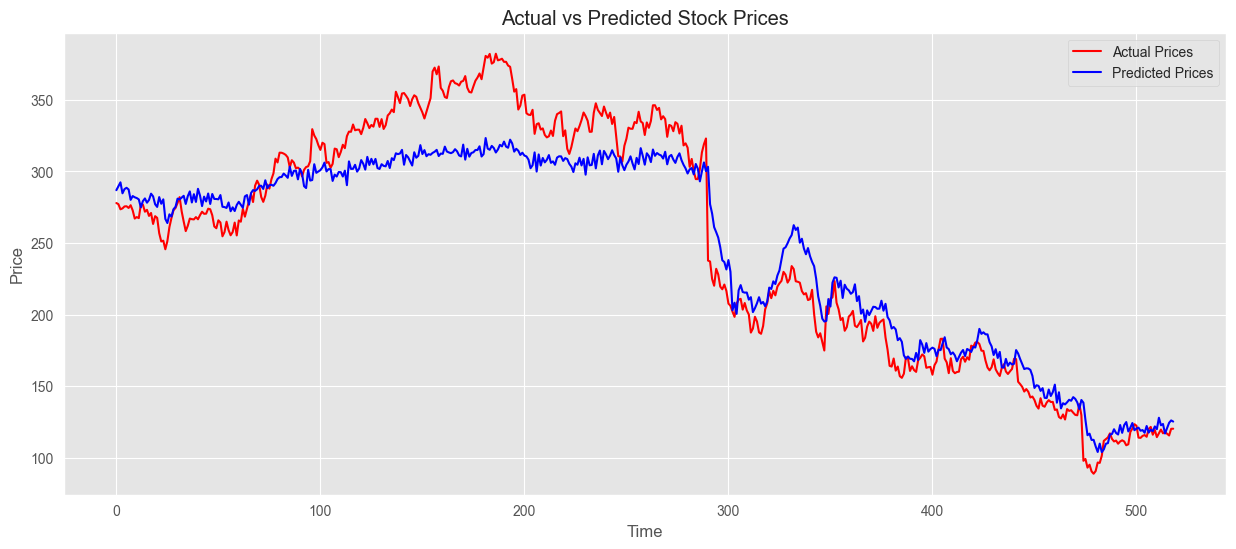

In [94]:
# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nFinal Model Performance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

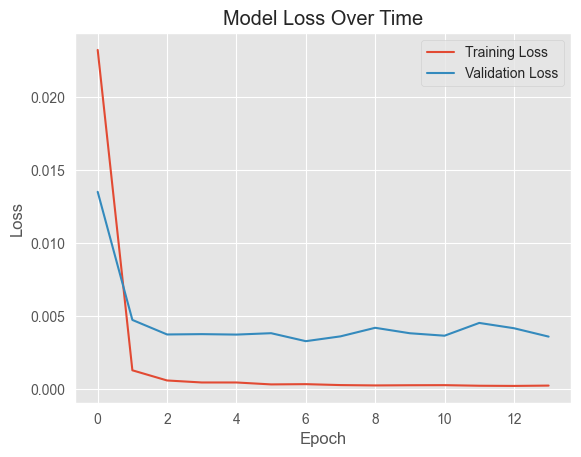

In [95]:
def plot_loss(training_losses, validation_losses):
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(training_losses, validation_losses)

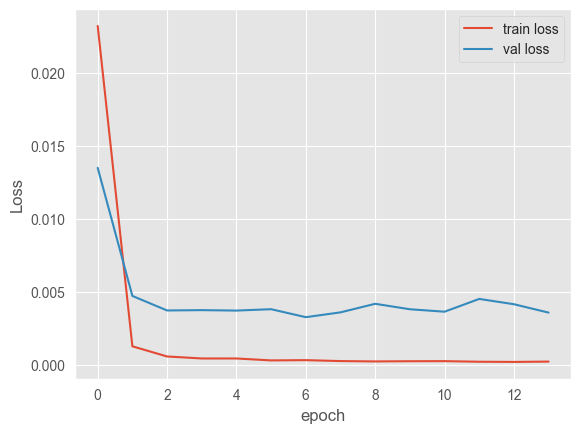

In [96]:
def plot_loss(loss, val_loss):
    plt.plot(loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(training_losses, validation_losses)